In [111]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import phik
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

## Введение


Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

__В работе планируется__:
- совершить предобработку данных и EDA
- создание метрик на основе предоставленных данных о покупках клиентов и коммуникаций с ними через разные каналы
- подбор оптимальных моделей МО и метрик к ним
- тестрование и оценка выбранной модели

## Загрузка данных

In [2]:
purchases = pd.read_csv('apparel-purchases.csv')
messages = pd.read_csv('apparel-messages.csv')
target = pd.read_csv('apparel-target_binary.csv')

In [3]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [4]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [6]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [7]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [8]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


## Предобработка данных

__Проверим датасеты на явные дубли и сразу избавимся от них__

In [9]:
for i in [purchases, messages, target]:
    print(i.duplicated().sum())

73020
48610
0


In [10]:
purchases[purchases.duplicated(keep=False)].head(10)

,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
41,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
58,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
61,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078


In [11]:
messages[messages.duplicated(keep=False)]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966465,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967281,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
...,...,...,...,...,...,...,...
12739720,14600,1515915625468103375,1515915625468103375-14600-65c2038646d16,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739721,14607,1515915625468103375,1515915625468103375-14607-65c33b1f402bb,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739722,14607,1515915625468103375,1515915625468103375-14607-65c33b1f402bb,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739730,14623,1515915625559065669,1515915625559065669-14623-65c5c5df06b3b,click,mobile_push,2024-02-15,2024-02-15 22:02:19


__К сожалению, исключить что было совершено по несколько покупок в день нельзя, так как отсуствует метка времени, а вот в messages явные дубли можно удалить__

In [12]:
messages = messages.drop_duplicates()

In [13]:
for i in [purchases, messages, target]:
    print(i.isna().sum())

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
client_id    0
target       0
dtype: int64


__Пропусков в 3х таблицах не имеем__

### Purchases

In [14]:
print(purchases['client_id'].nunique())
print(purchases['client_id'].count())

49849
202208


__Имеем в виду, что таблицу нужно будет группировать по клиентам__

In [15]:
purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

__Имеем разные значения quantity, но почти все записи имеет одну единицу товара__

In [16]:
purchases['category_ids'].nunique()

933

In [17]:
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)

In [18]:
all_categories = [category for sublist in purchases['category_ids'] for category in sublist]

In [19]:
len(set(all_categories))

1152

In [20]:
category_counts = pd.Series(all_categories).value_counts()
category_counts

4       112578
28       80143
5562     46511
2        27429
18       24314
         ...  
1102         1
5529         1
1726         1
751          1
1600         1
Name: count, Length: 1151, dtype: int64

__Категории__:
- имеем 933 уникальных "векторов" категорий товаров
- и 1151 уникальных категорий товаров если разделим списки

In [21]:
purchases['category_ids'] = purchases['category_ids'].apply(tuple)
client_categories = purchases.groupby('client_id')['category_ids'].nunique().sort_values(ascending=False)
client_categories

client_id
1515915625666901395    39
1515915625470860261    37
1515915625607113301    35
1515915625487144079    33
1515915625624308268    33
                       ..
1515915625563714195     1
1515915625563701736     1
1515915625489458296     1
1515915625563612955     1
1515915626010443624     1
Name: category_ids, Length: 49849, dtype: int64

In [22]:
client_categories.value_counts().sort_index()

category_ids
1     29074
2     10217
3      5579
4      2321
5      1059
6       618
7       341
8       230
9       122
10       73
11       65
12       28
13       26
14       26
15       12
16       16
17        3
18        6
19        6
20        7
21        2
22        4
23        2
24        2
26        1
27        1
29        1
30        1
31        1
33        2
35        1
37        1
39        1
Name: count, dtype: int64

In [23]:
client_categories.describe()

count    49849.000000
mean         1.880339
std          1.613424
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         39.000000
Name: category_ids, dtype: float64

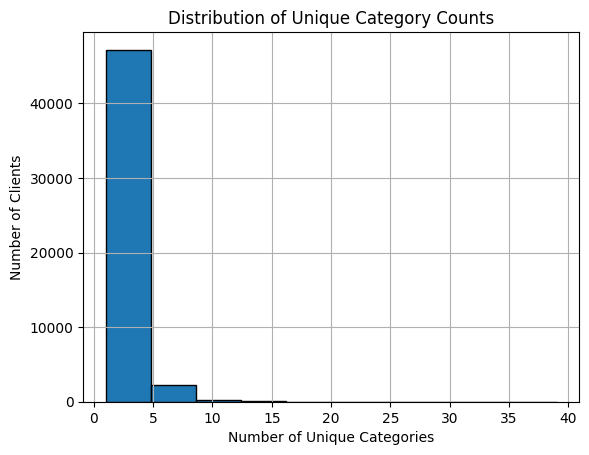

In [24]:
client_categories.hist(edgecolor='black')
plt.title('Distribution of Unique Category Counts')
plt.xlabel('Number of Unique Categories')
plt.ylabel('Number of Clients')
plt.show()

__75% клиентов покупают товары из максимум 2х категорий__

__Изучим временные метки__

In [25]:
purchases['date'] = pd.to_datetime(purchases['date'])

In [26]:
date_counts = purchases['date'].value_counts()
date_counts

date
2022-11-11    5270
2023-06-10    3836
2023-04-28    3473
2022-11-15    2937
2022-12-22    2631
              ... 
2023-08-06       4
2023-10-29       4
2023-01-09       3
2022-10-06       2
2023-01-29       2
Name: count, Length: 642, dtype: int64

In [27]:
purchases['date'].describe()

count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

In [28]:
monthly_counts = purchases['date'].dt.to_period('M').value_counts().sort_index()
monthly_counts

date
2022-05     4453
2022-06    14215
2022-07     9384
2022-08     7381
2022-09     5333
2022-10      741
2022-11    20732
2022-12    19382
2023-01     2680
2023-02     1900
2023-03    12173
2023-04    17501
2023-05     9966
2023-06    24888
2023-07    10218
2023-08     6367
2023-09     4428
2023-10     3237
2023-11     5870
2023-12    10452
2024-01     7175
2024-02     3732
Freq: M, Name: count, dtype: int64

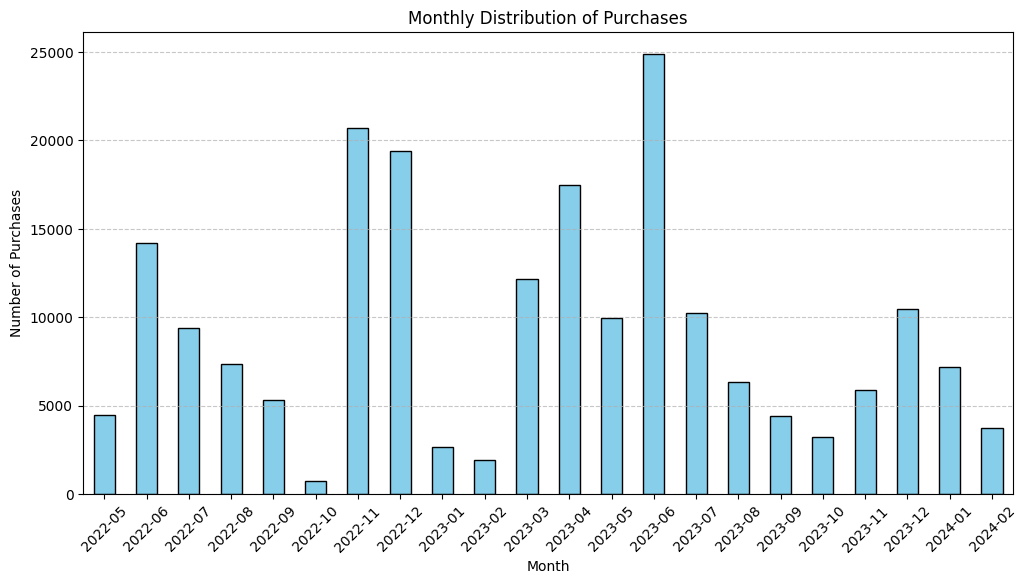

In [29]:
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Monthly Distribution of Purchases')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

__Даты покупок__:
- Имеем покупки с Апреля 2022 по Февраль 2024
- 642 уникальные даты
- подробная динамика по месяцам выше

In [30]:
purchases['price'].nunique()

3642

In [31]:
purchases['price'].describe()

count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

In [32]:
purchases.sort_values(by='price',ascending=False).head(5)

,client_id,quantity,price,category_ids,date,message_id
186736,1515915625553309277,1,85499.0,"(4, 29, 313, 1574)",2023-12-24,1515915625553309277-14352-6585585d7a711
166576,1515915625776653984,1,63499.0,"(4, 29, 310, 1577)",2023-08-26,1515915625776653984-13719-64e85f9332bc8
166578,1515915625776653984,1,60200.0,"(4, 29, 310, 1577)",2023-08-26,1515915625776653984-13719-64e85f9332bc8
138818,1515915625971673322,1,53499.0,"(4, 29, 310, 1577)",2023-06-13,1515915625971673322-13342-648873c693815
171436,1515915625959777467,1,52999.0,"(4, 29, 313, 1574)",2023-09-27,1515915625959777467-13868-6513cbb257da6


In [33]:
purchases.sort_values(by='price').head(5)

,client_id,quantity,price,category_ids,date,message_id
107691,1515915625500512811,1,1.0,"(4, 27, 278, 472)",2023-04-19,1515915625500512811-11968-643eaebebbd86
81608,1515915625908277092,1,1.0,"(4, 1822, 1821, 1815)",2022-12-31,1515915625553682046-9110-63ae8ebb4ed36
81607,1515915625908277092,1,1.0,"(4, 1822, 1821, 1815)",2022-12-31,1515915625553682046-9110-63ae8ebb4ed36
81606,1515915625908277092,1,1.0,"(4, 1822, 1821, 1815)",2022-12-31,1515915625553682046-9110-63ae8ebb4ed36
81605,1515915625908277092,1,1.0,"(4, 1822, 1821, 1815)",2022-12-31,1515915625553682046-9110-63ae8ebb4ed36


<Axes: >

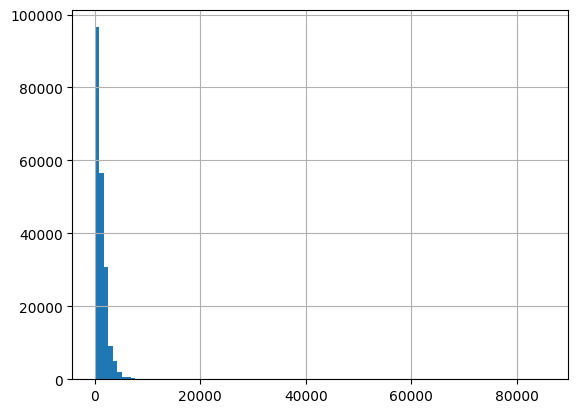

In [34]:
purchases['price'].hist(bins=100)

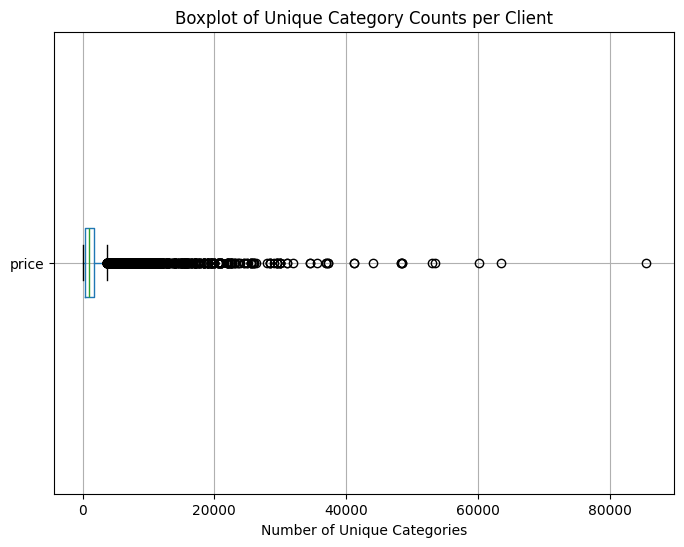

In [35]:
purchases.boxplot(column='price', vert=False, figsize=(8, 6), grid=True)
plt.title('Boxplot of Unique Category Counts per Client')
plt.xlabel('Number of Unique Categories')
plt.show()

__Цена__:
- 3642 уникальных значений
- среднее значение 1193.301516
- медиана 987.000000
- смещение распределения вправо из за выбросов
- 75% значений менее 1800 в валюте


__Добавим метрики для клиентов__:
- покупок за все время
- общая сумма покупок
- кол-во активных месяцев
- медианное кол во покупок в месяц
- медианная цена покупок в месяц
- кол_во категорий, в которых закупается клиент

In [36]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"(4, 28, 57, 431)",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"(4, 28, 57, 431)",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"(4, 28, 57, 431)",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"(4, 28, 244, 432)",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"(4, 28, 49, 413)",2022-05-16,1515915625471138230-4437-6282242f27843


In [37]:
temp_1 = purchases.pivot_table(index='client_id', values=['quantity','price'], aggfunc=['sum'])
temp_1.columns = ['tot_price', 'tot_qnt']

In [38]:
purchases['year_month'] = purchases['date'].dt.to_period('M')

In [39]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,year_month
0,1515915625468169594,1,1999.0,"(4, 28, 57, 431)",2022-05-16,1515915625468169594-4301-627b661e9736d,2022-05
1,1515915625468169594,1,2499.0,"(4, 28, 57, 431)",2022-05-16,1515915625468169594-4301-627b661e9736d,2022-05
2,1515915625471138230,1,6499.0,"(4, 28, 57, 431)",2022-05-16,1515915625471138230-4437-6282242f27843,2022-05
3,1515915625471138230,1,4999.0,"(4, 28, 244, 432)",2022-05-16,1515915625471138230-4437-6282242f27843,2022-05
4,1515915625471138230,1,4999.0,"(4, 28, 49, 413)",2022-05-16,1515915625471138230-4437-6282242f27843,2022-05


In [40]:
active_months = purchases.groupby('client_id')['year_month'].nunique().reset_index()
active_months.columns = ['client_id', 'active_months']

In [41]:
median_price_per_month = (
    purchases.groupby(['client_id', 'year_month'])['price'].median()
    .groupby('client_id').median().reset_index()
)
median_price_per_month.columns = ['client_id', 'median_price_per_month']

In [42]:
median_quantity_per_month = (
    purchases.groupby(['client_id', 'year_month'])['quantity'].median()
    .groupby('client_id').median().reset_index()
)
median_quantity_per_month.columns = ['client_id', 'median_quantity_per_month']

In [43]:
client_categories = client_categories.reset_index()
client_categories.columns = ['client_id','num_categories']

In [44]:
temp_2 = active_months.merge(median_price_per_month, on='client_id')
temp_2 = temp_2.merge(median_quantity_per_month, on='client_id')
temp_2 = temp_2.merge(client_categories, on='client_id')

In [45]:
purchases_metrics = temp_1.merge(temp_2, on='client_id', how='inner')

In [46]:
purchases_metrics.head()

,client_id,tot_price,tot_qnt,active_months,median_price_per_month,median_quantity_per_month,num_categories
0,1515915625468060902,6993.0,7,1,999.0,1.0,5
1,1515915625468061003,16235.0,7,1,2100.0,1.0,1
2,1515915625468061099,299.0,1,1,299.0,1.0,1
3,1515915625468061100,2098.0,2,1,1049.0,1.0,1
4,1515915625468061170,33601.0,19,2,1598.0,1.0,4


In [47]:
purchases_metrics.describe()

,client_id,tot_price,tot_qnt,active_months,median_price_per_month,median_quantity_per_month,num_categories
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,4840.520632,4.082710,1.142871,1469.151397,1.007668,1.880339
std,1.487947e+08,7312.865458,5.562927,0.487166,1395.723579,0.159711,1.613424
min,1.515916e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.515916e+18,1499.000000,1.000000,1.000000,660.000000,1.000000,1.000000
50%,1.515916e+18,2929.000000,2.000000,1.000000,1249.000000,1.000000,1.000000
75%,1.515916e+18,5677.000000,5.000000,1.000000,1999.000000,1.000000,2.000000
max,1.515916e+18,540408.000000,355.000000,10.000000,53499.000000,19.000000,39.000000


In [48]:
purchases_metrics.isna().sum()

client_id                    0
tot_price                    0
tot_qnt                      0
active_months                0
median_price_per_month       0
median_quantity_per_month    0
num_categories               0
dtype: int64

__Подготовили потенциальные метрики из Purchases__

### Messages

__Попробуем сразу добавить информацию по типам коммуникации из messages, так как в нашем датасете purchases, каждая покупка связана каким то образом с сообщением. Может все эти покупки произошли после какой то коммуникации, по крайней мере нам предоставили сообщение к каждой покупке из purchases__

__Проверим, что в messages каждому сообщению соответствует один тип event и chanel, чтобы добавить эти данные к purchases__

In [49]:
event_counts = messages.groupby('message_id')['event'].nunique()
all_single_event = (event_counts == 1).all()
print("All message_id have a single event:", all_single_event)

All message_id have a single event: False


In [50]:
event_counts.value_counts()

event
1    6027222
2    2766901
3     229926
4      37540
5         74
6          4
Name: count, dtype: int64

__Одному сообщению из messages соответствует больше одного статуса. Возможно, потому что заффиксированы все действия с сообщением, от отправки до открытия, клика, покупки, итд. Т.е. каждая покупка произошла на каком то статусе из жизни сообщения__

In [51]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 774.6+ MB


In [52]:
messages['created_at'] = pd.to_datetime(messages['created_at'])

In [53]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [54]:
messages['client_id'].nunique()

53329

In [55]:
messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

In [56]:
messages.sort_values(by=['message_id', 'created_at'])

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
3981325,10022,1515915625468060902,1515915625468060902-10022-63e5ededd911f,send,email,2023-02-10,2023-02-10 07:41:32
4059796,10218,1515915625468060902,1515915625468060902-10218-63ef56ed94656,send,email,2023-02-17,2023-02-17 10:30:29
4089474,10289,1515915625468060902,1515915625468060902-10289-63f35a8a9ff35,send,email,2023-02-20,2023-02-20 11:44:05
4128710,10373,1515915625468060902,1515915625468060902-10373-63f5cbba42484,send,email,2023-02-22,2023-02-22 08:13:16
4181838,10507,1515915625468060902,1515915625468060902-10507-63ff04f701e74,send,email,2023-03-01,2023-03-01 07:59:31
...,...,...,...,...,...,...,...
12707790,14648,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,send,mobile_push,2024-02-15,2024-02-15 07:08:21
12707814,14648,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,open,mobile_push,2024-02-15,2024-02-15 07:08:38
12739397,14648,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,click,mobile_push,2024-02-15,2024-02-15 16:23:39
12707477,14648,1515915626010288690,1515915626010288690-14648-65cdb6d29b698,send,mobile_push,2024-02-15,2024-02-15 07:04:47


__Посмотрим на сообщения с максимальными количествами ивентов, чтобы понять жизненный цикл сообщения__

In [57]:
event_counts = messages.groupby('message_id').size().reset_index(name='event_count')
max_event_count = event_counts['event_count'].max()
max_event_message_ids = event_counts[event_counts['event_count'] == max_event_count]['message_id']
lines_with_max_events = messages[messages['message_id'].isin(max_event_message_ids)].sort_values(by=['message_id', 'created_at'])

In [58]:
lines_with_max_events.head(25)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
1382528,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,send,email,2022-09-02,2022-09-02 07:46:54
1382934,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-02,2022-09-02 07:47:57
1402865,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-02,2022-09-02 21:32:47
1402869,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2022-09-02,2022-09-02 21:35:41
1402872,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2022-09-02,2022-09-02 21:38:42
1402878,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-02,2022-09-02 21:48:50
1402879,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-02,2022-09-02 21:48:58
1403447,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-03,2022-09-03 07:43:55
1403448,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2022-09-03,2022-09-03 07:44:19
1403472,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-03,2022-09-03 07:58:04


__Ну, судя по результату выше, одно сообщение может открываться и кликаться много раз, поэтому, идея с добавлением последнего статуса сообщения при покупке и дальнейшая аггрегация для клиентов отпадает.__

In [59]:
ordered_messages = (
    messages.groupby(['channel', 'event'])
    .size()
    .reset_index(name='count')  
    .sort_values(by=['channel', 'count'], ascending=[True, False]) 
)
print(ordered_messages)

        channel        event    count
6         email         send  3937221
4         email         open   873138
0         email        click   351949
5         email     purchase    44215
7         email  soft_bounce     9566
9         email  unsubscribe     2833
3         email     hbq_spam      823
1         email     complain      527
2         email  hard_bounce      359
8         email    subscribe       85
15  mobile_push         send  5120953
13  mobile_push         open  2179343
10  mobile_push        click   131377
12  mobile_push  hard_bounce    19404
14  mobile_push     purchase    18378
16  mobile_push  soft_bounce     1016
11  mobile_push        close        1


__Предлагаю добавить метрики с коммуникациями для клиентов__:
- медианное кол-во отправленных сообщений в месяц
- медианное кол-во открываний сообщений в месяц
- медианное кол-во совершенных кликов по сообщениям в месяц
- разбить эти метрики выше по каналам взаимодействий

In [60]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [61]:
messages['date'] = pd.to_datetime(messages['date'])
messages['date'] = messages['date'].dt.to_period('M')

In [62]:
messages['date'].value_counts().sort_index()

date
2022-05     163679
2022-06     401191
2022-07     434278
2022-08     371067
2022-09     382629
2022-10     469053
2022-11     615352
2022-12     617093
2023-01     394360
2023-02     326962
2023-03     449616
2023-04     361761
2023-05     402486
2023-06     603066
2023-07     607574
2023-08     776568
2023-09     745416
2023-10     789514
2023-11     874385
2023-12    1296440
2024-01    1123909
2024-02     484789
Freq: M, Name: count, dtype: int64

In [63]:
monthly_counts = (
    messages.groupby(['client_id', 'channel', 'date', 'event'])
    .size()
    .reset_index(name='event_count')
)

In [64]:
monthly_counts.head()

,client_id,channel,date,event,event_count
0,1515915625468060902,email,2022-05,click,4
1,1515915625468060902,email,2022-05,open,2
2,1515915625468060902,email,2022-05,purchase,5
3,1515915625468060902,email,2022-05,send,4
4,1515915625468060902,email,2022-06,open,4


In [65]:
pivot_counts = monthly_counts.pivot_table(
    index=['client_id', 'channel', 'date'],
    columns='event',
    values='event_count',
    aggfunc='sum',
    fill_value=0
).reset_index()

In [66]:
pivot_counts.head()

event,client_id,channel,date,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,email,2022-05,4,0,0,0,0,2,5,4,0,0,0
1,1515915625468060902,email,2022-06,0,0,0,0,0,4,0,11,0,0,0
2,1515915625468060902,email,2022-07,0,0,0,0,0,2,0,7,0,0,0
3,1515915625468060902,email,2022-08,0,0,0,0,0,1,0,2,0,0,0
4,1515915625468060902,email,2022-09,2,0,0,0,0,4,0,6,0,0,0


In [67]:
median_metrics = (
    pivot_counts.groupby(['client_id', 'channel'])[['send', 'open', 'click']]
    .median()
    .reset_index()
)

In [68]:
median_metrics.head()

event,client_id,channel,send,open,click
0,1515915625468060902,email,6.0,1.0,0.0
1,1515915625468061003,email,7.5,0.0,0.0
2,1515915625468061099,email,7.5,0.5,0.0
3,1515915625468061099,mobile_push,9.5,3.0,0.0
4,1515915625468061100,mobile_push,16.0,8.5,0.0


In [69]:
final_metrics = median_metrics.pivot(index='client_id', columns='channel', values=['send', 'open', 'click'])

In [70]:
final_metrics.head()

send              open             click            
channel             email mobile_push email mobile_push email mobile_push
client_id                                                                
1515915625468060902   6.0         NaN   1.0         NaN   0.0         NaN
1515915625468061003   7.5         NaN   0.0         NaN   0.0         NaN
1515915625468061099   7.5         9.5   0.5         3.0   0.0         0.0
1515915625468061100   NaN        16.0   NaN         8.5   NaN         0.0
1515915625468061170   7.0        12.0   1.0         1.0   0.0         0.0

In [71]:
final_metrics.columns = [
    f"{channel}_median_{event}s_month"
    for event, channel in final_metrics.columns
]

In [72]:
final_metrics = final_metrics.reset_index()
final_metrics.head()

,client_id,email_median_sends_month,mobile_push_median_sends_month,email_median_opens_month,mobile_push_median_opens_month,email_median_clicks_month,mobile_push_median_clicks_month
0,1515915625468060902,6.0,NaN,1.0,NaN,0.0,NaN
1,1515915625468061003,7.5,NaN,0.0,NaN,0.0,NaN
2,1515915625468061099,7.5,9.5,0.5,3.0,0.0,0.0
3,1515915625468061100,NaN,16.0,NaN,8.5,NaN,0.0
4,1515915625468061170,7.0,12.0,1.0,1.0,0.0,0.0


In [73]:
final_metrics.shape

(53329, 7)

In [74]:
final_metrics.isna().sum()

client_id                              0
email_median_sends_month           14242
mobile_push_median_sends_month     16393
email_median_opens_month           14242
mobile_push_median_opens_month     16393
email_median_clicks_month          14242
mobile_push_median_clicks_month    16393
dtype: int64

In [75]:
messages_metrics = final_metrics.fillna(0)

In [76]:
messages_metrics.describe()

,client_id,email_median_sends_month,mobile_push_median_sends_month,email_median_opens_month,mobile_push_median_opens_month,email_median_clicks_month,mobile_push_median_clicks_month
count,5.332900e+04,53329.00000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000
mean,1.515916e+18,4.03665,7.244351,0.818045,3.237957,0.329267,0.106162
std,1.585540e+08,3.17985,5.951700,1.472805,5.066595,1.077673,0.515542
min,1.515916e+18,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,5.00000,8.500000,0.000000,0.000000,0.000000,0.000000
75%,1.515916e+18,7.00000,12.000000,1.000000,6.500000,0.000000,0.000000
max,1.515916e+18,15.00000,120.500000,38.000000,119.500000,88.000000,18.000000


__Метрики с коммуникациями групированные по клиентам готовы и описаны выше__

### Final metrics

__Объединим все таблицы__

In [77]:
purchases_metrics.head()

,client_id,tot_price,tot_qnt,active_months,median_price_per_month,median_quantity_per_month,num_categories
0,1515915625468060902,6993.0,7,1,999.0,1.0,5
1,1515915625468061003,16235.0,7,1,2100.0,1.0,1
2,1515915625468061099,299.0,1,1,299.0,1.0,1
3,1515915625468061100,2098.0,2,1,1049.0,1.0,1
4,1515915625468061170,33601.0,19,2,1598.0,1.0,4


In [78]:
messages_metrics.head()

,client_id,email_median_sends_month,mobile_push_median_sends_month,email_median_opens_month,mobile_push_median_opens_month,email_median_clicks_month,mobile_push_median_clicks_month
0,1515915625468060902,6.0,0.0,1.0,0.0,0.0,0.0
1,1515915625468061003,7.5,0.0,0.0,0.0,0.0,0.0
2,1515915625468061099,7.5,9.5,0.5,3.0,0.0,0.0
3,1515915625468061100,0.0,16.0,0.0,8.5,0.0,0.0
4,1515915625468061170,7.0,12.0,1.0,1.0,0.0,0.0


In [79]:
print(purchases_metrics.shape)
print(messages_metrics.shape)

(49849, 7)
(53329, 7)


In [80]:
target.shape

(49849, 2)

In [81]:
final_df = target.merge(purchases_metrics, on='client_id', how='left')
final_df = final_df.merge(messages_metrics, on='client_id', how='left')

In [82]:
final_df.head()

,client_id,target,tot_price,tot_qnt,active_months,median_price_per_month,median_quantity_per_month,num_categories,email_median_sends_month,mobile_push_median_sends_month,email_median_opens_month,mobile_push_median_opens_month,email_median_clicks_month,mobile_push_median_clicks_month
0,1515915625468060902,0,6993.0,7,1,999.0,1.0,5,6.0,0.0,1.0,0.0,0.0,0.0
1,1515915625468061003,1,16235.0,7,1,2100.0,1.0,1,7.5,0.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0,299.0,1,1,299.0,1.0,1,7.5,9.5,0.5,3.0,0.0,0.0
3,1515915625468061100,0,2098.0,2,1,1049.0,1.0,1,0.0,16.0,0.0,8.5,0.0,0.0
4,1515915625468061170,0,33601.0,19,2,1598.0,1.0,4,7.0,12.0,1.0,1.0,0.0,0.0


In [83]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   client_id                        49849 non-null  int64  
 1   target                           49849 non-null  int64  
 2   tot_price                        49849 non-null  float64
 3   tot_qnt                          49849 non-null  int64  
 4   active_months                    49849 non-null  int64  
 5   median_price_per_month           49849 non-null  float64
 6   median_quantity_per_month        49849 non-null  float64
 7   num_categories                   49849 non-null  int64  
 8   email_median_sends_month         41982 non-null  float64
 9   mobile_push_median_sends_month   41982 non-null  float64
 10  email_median_opens_month         41982 non-null  float64
 11  mobile_push_median_opens_month   41982 non-null  float64
 12  email_median_click

__Заполним пропуски для ненайденных клиентов из messages средниими значениями__

In [84]:
final_df = final_df.fillna(final_df.mean())

In [85]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   client_id                        49849 non-null  int64  
 1   target                           49849 non-null  int64  
 2   tot_price                        49849 non-null  float64
 3   tot_qnt                          49849 non-null  int64  
 4   active_months                    49849 non-null  int64  
 5   median_price_per_month           49849 non-null  float64
 6   median_quantity_per_month        49849 non-null  float64
 7   num_categories                   49849 non-null  int64  
 8   email_median_sends_month         49849 non-null  float64
 9   mobile_push_median_sends_month   49849 non-null  float64
 10  email_median_opens_month         49849 non-null  float64
 11  mobile_push_median_opens_month   49849 non-null  float64
 12  email_median_click

## Анализ Phik

In [86]:
final_df = final_df.drop(columns='client_id')

In [87]:
interval_cols = [
    'tot_price', 'tot_qnt','median_price_per_month', 
    'median_quantity_per_month', 
    'email_median_sends_month', 'mobile_push_median_sends_month', 
    'email_median_opens_month', 'mobile_push_median_opens_month', 
    'email_median_clicks_month', 'mobile_push_median_clicks_month'
]
corr_matrix = final_df.phik_matrix(interval_cols=interval_cols)

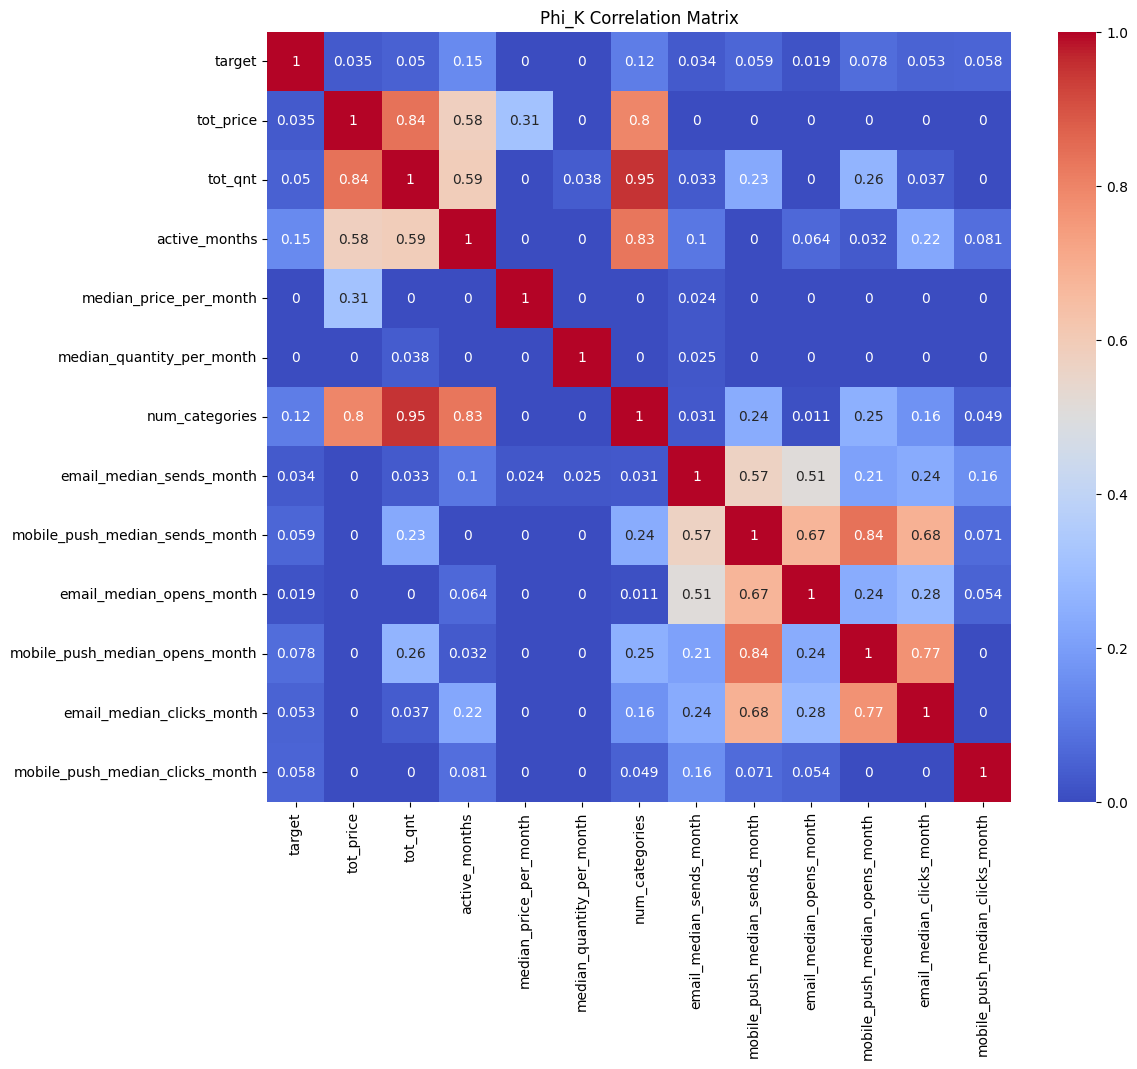

In [88]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

__Фик__:
- имеем мультиколлинеарность между признаками общее кол-во купленных единиц и общее кол-во категорий, в которых закупался клиент. Избавимся от tot_qnt, оставим признак с большей связью с целевым, согласно шкале Чеддока.
- не будем брать признаки median_price_per_month, median_quantity_per_month, так как согласно Фик коефициентам выше, нет никакой связи с целевым признаком.
- связи остальных признаков с целевым малы, но имеются

In [89]:
final_df = final_df.drop(columns=['tot_qnt', 'median_price_per_month', 'median_quantity_per_month'])

## Обучение моделей

In [90]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [91]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   target                           49849 non-null  int64  
 1   tot_price                        49849 non-null  float64
 2   active_months                    49849 non-null  int64  
 3   num_categories                   49849 non-null  int64  
 4   email_median_sends_month         49849 non-null  float64
 5   mobile_push_median_sends_month   49849 non-null  float64
 6   email_median_opens_month         49849 non-null  float64
 7   mobile_push_median_opens_month   49849 non-null  float64
 8   email_median_clicks_month        49849 non-null  float64
 9   mobile_push_median_clicks_month  49849 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 3.8 MB


In [92]:
X = final_df.drop(columns='target')
y = final_df['target']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify=y
                                                    )

In [94]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(37386, 9) (12463, 9) (37386,) (12463,)


In [95]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), slice(0, X.shape[1]))
    ],
    remainder='passthrough' 
)

__Так как один общий пайплайн очень долго считается, предлагаю сделать отдельные пайплайны для моделей, с перебором различных гиперпараметров. Выбор модели осуществим на основании метрики Roc Auc, полученной на кросс валидации с тремя блоками__

__ROC-AUC__:
- Кривая ROC – это график, который иллюстрирует производительность классификационной модели при всех возможных порогах классификации.
- ROCAUC это мера, которая позволяет суммировать производительность модели одним числом, измеряя площадь под кривой ROC. AUC колеблется от 0 до 1, где более высокое значение AUC указывает на более высокую производительность модели. AUC равный 0.5 указывает на отсутствие дискриминационной способности модели, тогда как AUC равный 1.0 означает идеальное различие классов.

__Попробуем следующие модели и перебор гиперпараметров посредством randomizedsearch__:
- LogisticRegression
- DecisionTreeClassifier
- KNeighborsClassifier
- GradientBoostingClassifier
- RandomForestClassifier

- SVC очень долго обучается, исключил ее

In [96]:
param_grid_lr = {
    'models__C': range(1,50),  
    'models__penalty': ['l1', 'l2'],       
    'models__solver': ['liblinear'],       
}

pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

randomized_search_lr = RandomizedSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=3,
    scoring='roc_auc',
    
    random_state=RANDOM_STATE,
    n_jobs=-1 
)

randomized_search_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                               slice(0, 9, None))])),
                                             ('models',
                                              LogisticRegression(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'models__C': range(1, 50),
                                        'models__penalty': ['l1', 'l2'],
                                        'models__solver': ['liblinear']},
                   random_state=42, scoring='roc_auc')

In [97]:
randomized_search_lr.best_score_

0.6729128882947589

In [98]:
param_grid_dt = {
    'models__max_depth': [2, 3, 4, 5],
    'models__max_features': [5, 6, 7, 8], 
}

pipe_dt = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

randomized_search_dt = RandomizedSearchCV(
    pipe_dt,
    param_grid_dt,
    cv=3,
    scoring='roc_auc',
    
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                               slice(0, 9, None))])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'models__max_depth': [2, 3, 4, 5],
                                        'models__max_features': [5, 6, 7, 8]},
                   random_state=42, scoring='roc_auc')

In [99]:
randomized_search_dt.best_score_

0.6452546862037623

In [100]:
param_grid_knn = {
    'models__n_neighbors': range(2, 20),     
    'models__weights': ['uniform', 'distance'],  
    'models__p': [1, 2],                    
}


pipe_knn = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])


randomized_search_knn = RandomizedSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=3,
    scoring='roc_auc',
    
    random_state=RANDOM_STATE,
    n_jobs=-1
)


randomized_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                               slice(0, 9, None))])),
                                             ('models',
                                              KNeighborsClassifier())]),
                   n_jobs=-1,
                   param_distributions={'models__n_neighbors': range(2, 20),
                                        'models__p': [1, 2],
                                        'models__weights': ['uniform',
                                                            'distance']},
                   random_state=42, scoring='roc_auc')

In [101]:
randomized_search_knn.best_score_

0.5777627460375331

In [102]:
param_grid_gb = {
    'models__n_estimators': [100, 200, 300], 
    'models__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'models__max_depth': [3, 5, 7, 9],
    'models__subsample': [0.6, 0.8, 1.0],  # Try smaller subsample values
}


pipe_gb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Perform randomized search for GradientBoostingClassifier
randomized_search_gb = RandomizedSearchCV(
    pipe_gb,
    param_grid_gb,
    cv=3,
    scoring='roc_auc',
   
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the model on the training data
randomized_search_gb.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                               slice(0, 9, None))])),
                                             ('models',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'models__learning_rate': [0.01, 0.05,
                                                                  0.1, 0.2],
                                        'models__max_depth': [3, 5, 7, 9],
                                        'models__n_estimators': [100, 200, 300],
                                        'models__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc')

In [103]:
randomized_search_gb.best_score_

0.6853592427091608

In [104]:
param_grid_rf = {
    'models__n_estimators': [100, 200, 300],  # Number of trees
    'models__max_depth': [3, 5, 7, None],    # Maximum depth of the trees
    'models__min_samples_split': [2, 5, 10], # Minimum samples required to split an internal node
    'models__min_samples_leaf': [1, 2, 4],   # Minimum samples required at a leaf node
    'models__max_features': ['sqrt', 'log2', None], # Number of features considered for splitting
    'models__bootstrap': [True, False],      # Whether to use bootstrapping
}

# Create a pipeline for RandomForestClassifier
pipe_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Perform randomized search for RandomForestClassifier
randomized_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=3,
    scoring='roc_auc',
    
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the model on the training data
randomized_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                               slice(0, 9, None))])),
                                             ('models',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'models__bootstrap': [True, False],
                                        'models__max_depth': [3, 5, 7, None],
                                        'models__max_features': ['sqrt', 'log2',
                                                                 None],
                                        'models__min_samples_leaf': [1, 2, 4],
                                        'models__min_samples_split': [2, 5, 10],
                                        'models__n_estimators': [100, 200,
                                                                 300]},
                   random_state=42, scoring='roc_auc')

In [105]:
randomized_search_rf.best_score_

0.68773895908845

In [106]:
randomized_search_rf.best_params_

{'models__n_estimators': 200,
 'models__min_samples_split': 2,
 'models__min_samples_leaf': 4,
 'models__max_features': 'sqrt',
 'models__max_depth': 7,
 'models__bootstrap': True}

__Итак, в результате лидер среди моделей RandomForestClassifier с параметрами выше__:
- Метрика ROC AUC на кросс валидации составила 0,69. Т.е. у модели шанс 70% шанс правильно осуществить классификацию

## Тестирование модели

In [107]:
best_rf_model = randomized_search_rf.best_estimator_

In [108]:
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score на тестовых даных: {roc_auc:.4f}")

ROC-AUC Score на тестовых даных: 0.6953


__Построим confusion matrix__

Confusion Matrix:
[[12223     0]
 [  240     0]]


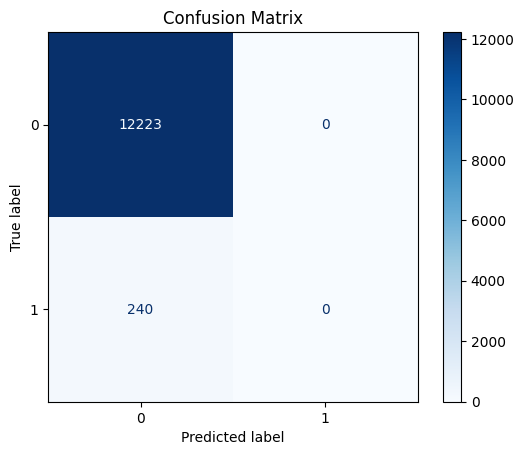

In [109]:
y_pred = best_rf_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

__Модель__:
- отлично предсказала клиентов не совершающих покупки, True Negatives 12223, модель хорошо определяет отрицательный класс
- FP = 0 , модель не назначила положительный класс, отрицательным
- но модель совсем не определила True Positives, 240 которые купят, предсказан класс отрицательный
- ну и TP равен 0

__Т.е. модель очень хорошо опредяется отрицательный класс, но совсем не отделяет положительный__

__Можно попробовать изменить пороговые значения для улучшения recall пожертвуя precision__
- построим график зависимости threshold и precision-recall
- выберем оптимальное значение
- еще раз взглянем на confusion matrix

In [112]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

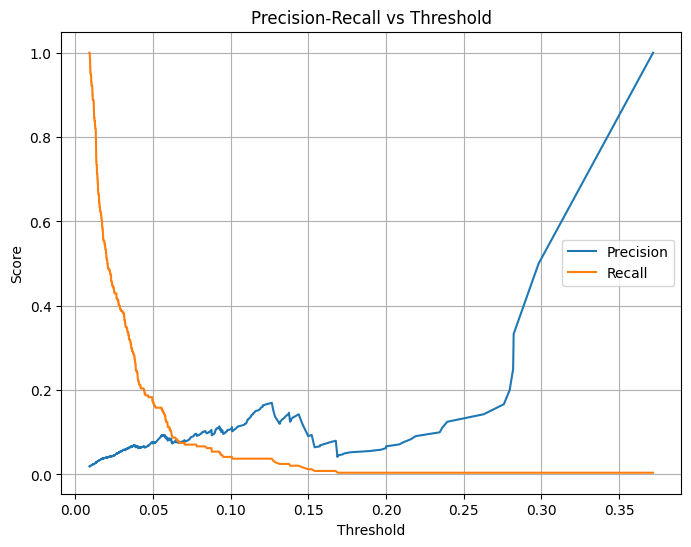

In [113]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [123]:
y_pred_custom = (y_pred_proba >= 0.05).astype(int)

Confusion Matrix with Threshold 0.06:
[[11714   509]
 [  199    41]]


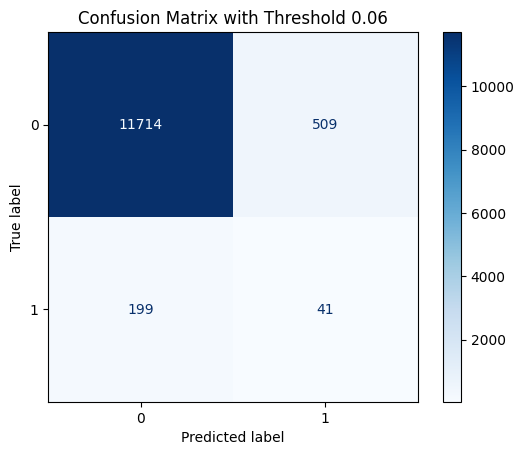

In [124]:
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix with Threshold 0.06:")
print(conf_matrix_custom)
disp_custom = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_custom, display_labels=[0, 1])
disp_custom.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Threshold 0.06")
plt.show()

__Как видно на графике выше, мы можем улучшить recall, модель корректно присвоит положительный класс 41 из 240 клиентов, но также 509 клиентам ошибочно будет присвоен этот класс__

## Вывод

__Проведена подготовка данных__:
- выполнена предобработка и EDA
- созданы метрики на основе покупок клиентов
- созданы метрики на основе коммуникаций с клиентами

__Проведен анализ Фик, исключена мультиколлинерарность признаков и отобраны итоговые признаки для обучения моделей__

__МО__:
- проведено обучение и подбор гиперпараметров различных моделей:
 - LogisticRegression
 - DecisionTreeClassifier
 - KNeighborsClassifier
 - GradientBoostingClassifier
 - RandomForestClassifier

__Отобрана лучшая модель по метрике ROC AUC: RandomForestClassifier__:
- Проведено тестирование на отобранной выборке. Достигнутое значение метрики 0,7

__Проведен анализ Confusion Matrix__:
- Модель хорошо опредяется отрицательный класс, но совсем не отделяет положительный
- был эксперементально проанализирован эффект изменения threshold